In [ ]:
# pip install xgboost
# %pip install graphviz

In [1]:
from xgboost import XGBRegressor
import pandas as pd 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Importing excel sheets as dfs, should both have samples in the same order
predictors_df = pd.read_excel('../Predictors_Cleaned.xlsx', 0)
    # Rows are samples, columns are predictors
outcomes_df = pd.read_excel('../Outcomes_Cleaned.xlsx', 0)
    # Rows are samples, columns are mechanisms

# Dropping unnecessary metadata
X = predictors_df.drop('SAMPLE NAME', axis=1)
Y = outcomes_df.drop('MECHANISM', axis=1) # Full DF must iterate through
feature_names = X.columns

# List of columns for iterating
columns = list(Y)

r2_list = []
# print(predictors_df) # 211 x 33
# print(outcomes_df) # 211 x 41

In [3]:
for i in columns:
    
    # resetting the r2 and best model value for each column
    r2 = 0
    best_model = XGBRegressor()
    
    # Iterate through common proportions of test/train data
    for j in [0.2, 0.4, 0.6, 0.8]:

        # Split Data
        x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=j) 

        # Iterate through common n_estimators
        for k in [100, 500, 1000]:

            # Create model
            xg = XGBRegressor(n_estimators=k) 
            xg = xg.fit(x_train, y_train)

            # Find model r squared
            predictions = xg.predict(x_test)
            new_r2 = abs(r2_score(y_test, predictions)) # using absolute value for comparision

            # Compare model, if model r2 is over 1 then its very bad fit so we don't save it
            if new_r2 <= 1:
                if new_r2 > r2:
                    r2 = new_r2
                    # Saving the better model
                    best_model = xg
                    # Saving best model params for visualization
                    best_x_test = x_test
                    best_y_test = y_test
    
    # Finally dumping the best model for the class
    joblib.dump(best_model, f"Models/xgb_{i}.joblib")

    # Storing highest r2
    r2_list.append(r2)

    # Visualizing Tree
    plt.figure()  
    plot_tree(best_model) 
    plt.gcf().set_size_inches(60, 40)
    plt.savefig(f'Trees/{i}_tree.png')
    plt.close()

    # Visualizing feature importance
    perm_importance = permutation_importance(best_model, best_x_test, best_y_test)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.gcf().set_size_inches(10, 7)
    plt.xlabel(f"{i} Permutation Importance")
    plt.savefig(f'Features/{i}_features.png')
    plt.close()

    # Printing r2
    print(f"{i} r2: {r2}")
    

Lipopeptides r2: 0.8686336278915405
Arsenic_resistance r2: 0.3239036798477173
Copper_resistance r2: 0.7392251491546631
Rifampin r2: 0.507596492767334
Trimethoprim r2: 0.19566500186920166
Tellurim_resistance r2: 0.38222718238830566
Zinc_resistance r2: 0.577293872833252
Peroxide_resistance r2: 0.7742315530776978
Multi-drug_resistance r2: 0.3699702024459839
Acid_resistance r2: 0.7305279970169067
Phenolic_compound_resistance r2: 0.8734515905380249
Mupirocin r2: 0.023809313774108887
Nucleosides r2: 0.2037581205368042
Aldehyde_resistance r2: 0.5877387523651123
Paraquat_resistance r2: 0.12919366359710693
Betalactams r2: 0.19670379161834717
Tetracyclines r2: 0.126448392868042
Nickel_resistance r2: 0.17040085792541504
Multibiocide_resistance r2: 0.21986711025238037
Aminoglycoside r2: 0.31910061836242676
MLS r2: 0.24485158920288086
Fluoroquinolones r2: 0.31012558937072754
Fosfomycin r2: 0.13290870189666748
Phenicol_resistance r2: 0.3920304775238037
Drug_and_biocide_resistance r2: 0.1874570846557

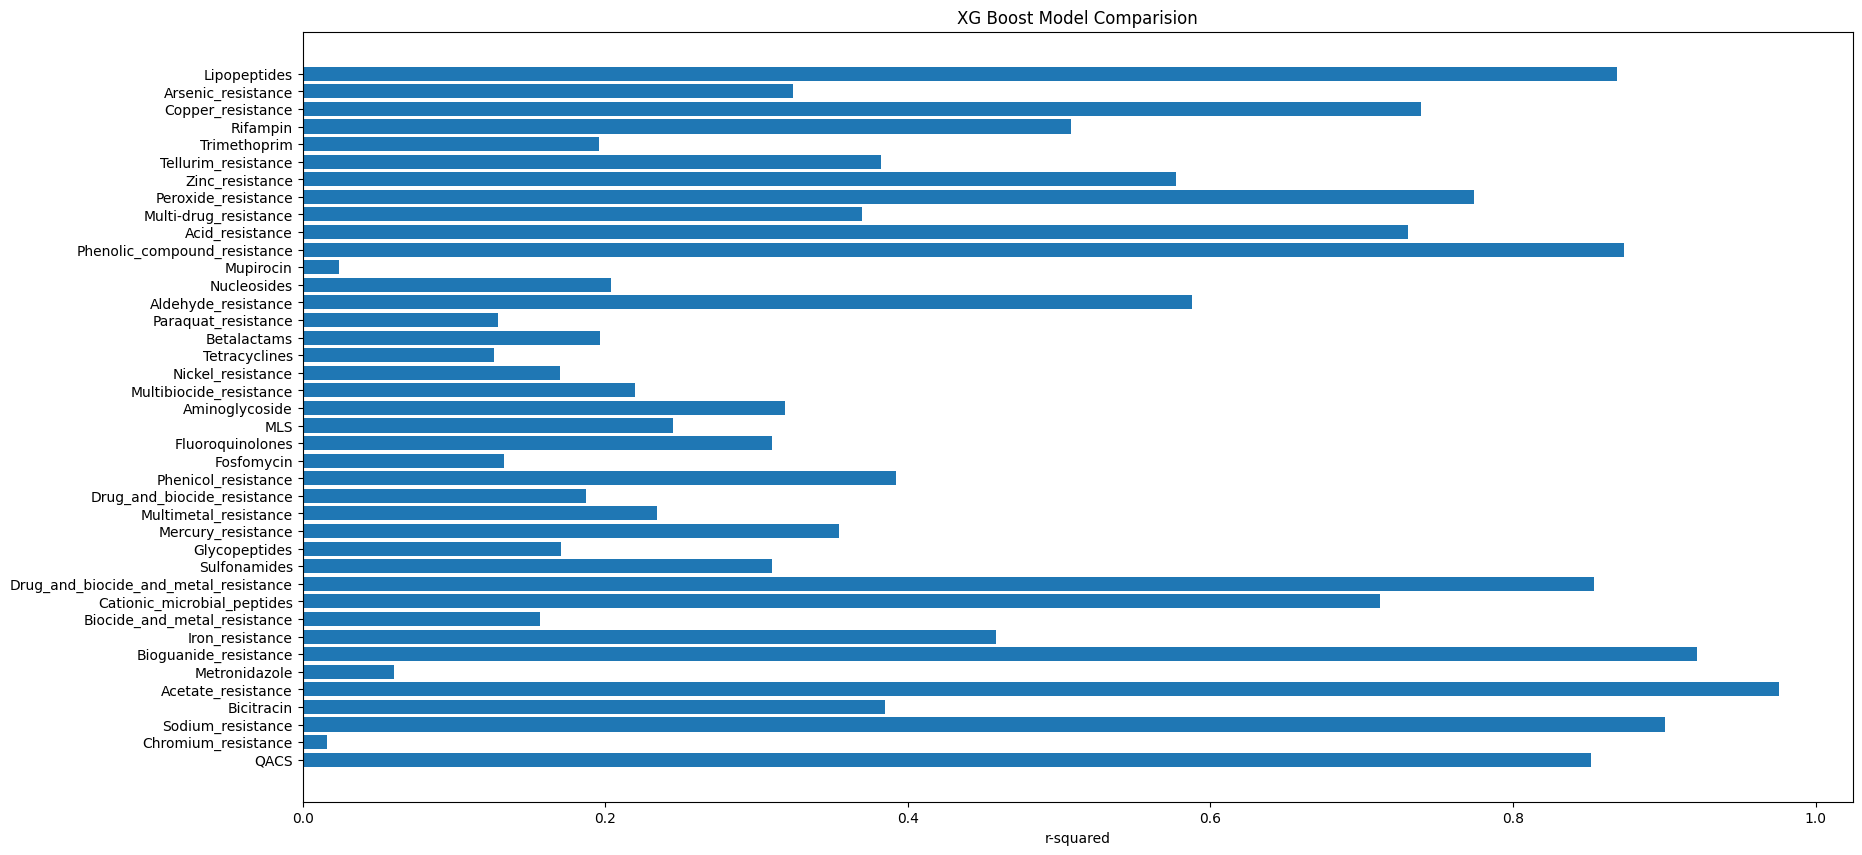

In [5]:
# Plotting an overall comparision of different models and their r2 scores
import numpy as np

fig, ax = plt.subplots(figsize=(20,10))

ax.barh(np.arange(len(columns)), r2_list, align='center')
ax.set_yticks(np.arange(len(columns)), labels=columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('r-squared')
ax.set_title('XG Boost Model Comparision')

plt.show()